# Data Cleaning
- Load data that has been processed in OpenRefine and make some general tweaks
- Split est_price into quantity and price columns
    - Cleanup quantity units and convert all values to single unit
    - Cleanup and standardize currency symbols
- Load historical exchange rate data, and convert all data to historical USD using the exchange rate from the month of the 
review date
- Load consumer price index data from BLS. Use this to convert all historical USD prices to January 2024 USD prices
- Cleanup geographic data
    - Create a column for all counties
    - Create a column for US State
    - Check country column is only countries

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', None)
mpl.rcParams['figure.dpi']= 300

In [2]:
# Read in raw data
data_dir = Path('../../data')
file_path = data_dir / 'interim' / '05052024_roast_review_openrefine.csv'
df_raw = pd.read_csv(file_path)

display(df_raw.info())
display(df_raw.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6539 entries, 0 to 6538
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rating                            6539 non-null   int64  
 1   roaster                           6539 non-null   object 
 2   title                             6539 non-null   object 
 3   blind_assessment                  6539 non-null   object 
 4   bottom_line                       3260 non-null   object 
 5   roaster_location                  6538 non-null   object 
 6   coordinate location               6538 non-null   object 
 7   og_roaster_location               6537 non-null   object 
 8   roaster_location_identifier       6538 non-null   object 
 9   territorial_entity_1              6531 non-null   object 
 10  territorial_entity_1_identifiers  6531 non-null   object 
 11  territorial_entity_2              5889 non-null   object 
 12  territ

None

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,territorial_entity_1_identifiers,territorial_entity_2,territorial_entity_2_identifiers,roaster_country,coffee_origin,coffee_origin_country,roast_level,agtron,est_price,review_date,aroma,body,flavor,aftertaste,with_milk,url,acidity/structure,acidity,notes
3535,92,Wild Goose Coffee Roasters,Panama Lerida,"Sweetly and gently floral. Honey, jasmine, lem...",NaN,Redlands,"34.054722222222,-117.1825","Redlands, California",Q753830,San Bernardino County,Q108053,California,Q99,USA,"Boquete growing region, Panama",Panama,Light,63/88,$17.75/12 ounces,May 2015,9.0,8.0,9.0,8.0,NaN,https://www.coffeereview.com/review/panama-ler...,NaN,8,From the celebrated Panama farm Finca Lerida. ...
2218,95,Kakalove Cafe,Kenya Kiambu Uklili AA,"High-toned, richly savory-sweet. Red currant, ...","A harmonious, lyrical, balanced Kenya coffee, ...",Chiayi City,"23.48,120.44972222222","Chia-Yi, Taiwan",Q249995,Taiwan Province,Q32081,Taiwan,Q865,Taiwan,"Kiambu Growing Region, Kenya",Kenya,Medium,52/68,NT $350/8 ounces,August 2019,9.0,9.0,9.0,9.0,NaN,https://www.coffeereview.com/review/kenya-kiam...,9.0,NaN,Despite challenges ranging from unclear govern...
6065,93,Ecco Caffe,Daterra Reserve,Both Ken and co-taster Ted Lingle remarked on ...,NaN,Santa Rosa,"38.448611111111,-122.70472222222","Santa Rosa, California",Q212991,Sonoma County,Q108067,California,Q99,USA,"Cerrado growing region, Minas Gerais State, Br...",Brazil,Medium,45/57,NaN,September 2005,9.0,9.0,9.0,8.0,8.0,https://www.coffeereview.com/review/daterra-re...,NaN,NaN,"Daterra is a large, technically sophisticated ..."
3814,88,Allegro Coffee,Organic Peru Cecovasa,"Deep, quiet, gently chocolaty. Hazelnut, dark ...",NaN,Thornton,"39.9031,-104.954","Thornton, Colorado",Q579761,Adams County,Q112807,Colorado,Q1261,USA,Peru,Peru,Medium,55/62,$11.99/12 ounces,June 2014,8.0,7.0,8.0,8.0,NaN,https://www.coffeereview.com/review/organic-pe...,NaN,7,"Produced by farmer members of CECOVASA, an ass..."
3987,92,Blueprint Coffee,Kagomoini Kenya,"Richly pungent, cleanly fruit-toned. Ripe oran...",NaN,St. Louis,"38.62638888888889,-90.19944444444444","St. Louis, Missouri",Q38022,Missouri,Q1581,United States of America,Q30,USA,"Nyeri growing region, Kenya",Kenya,Medium-Light,55/74,$31.50/12 ounces,November 2013,8.0,9.0,9.0,8.0,NaN,https://www.coffeereview.com/review/kagomoini-...,NaN,8,From trees of the much-admired SL28 and SL34 v...


In [3]:
def tweak_df(df: pd.DataFrame) -> pd.DataFrame:
    """Initial data tweak"""
    return(
        df
        .assign(review_date = lambda df_: pd.to_datetime(df_['review_date'], format="%B %Y"),
                # Combing acidity and acidity/structure into one column, they are the same 
                # field but names used in reviews changed at one point
                acidity = lambda df_: df_['acidity'].fillna(df_['acidity/structure']),
                # Split the agtron column into one for external bean agtron data and ground 
                # bean agtron data
                agtron_external=lambda x: pd.to_numeric(x['agtron']
                                    .str.split('/', expand=True)[0]
                                    .str.strip(), errors='coerce'),
                agtron_ground = lambda x: pd.to_numeric(x['agtron']
                                        .str.split('/', expand=True)[1]
                                        .str.strip(), errors='coerce'
                                        )
        )
        .dropna(subset=['agtron_external', 'agtron_ground', 'acidity',
                        'review_date', 'est_price', 'coffee_origin',
                        'aroma', 'roast_level', 'aftertaste',]
        )
        .drop(columns=['with_milk', 'acidity/structure',])
        .astype({'acidity': 'float'})
        .replace('', np.nan)
        # Agtron values must be equalt to or below 100, some entries on website have typos 
        .loc[lambda df_: (df_['agtron_external'] <= 100) & (df_['agtron_ground'] <= 100), :]
        # Run str.strip on every string column
        .applymap(lambda x: x.strip() if isinstance(x, str) else x)
    )

df = df_raw.pipe(tweak_df)

display(df.info())
display(df.sample(3))


<class 'pandas.core.frame.DataFrame'>
Index: 4375 entries, 1 to 5163
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4375 non-null   int64         
 1   roaster                           4375 non-null   object        
 2   title                             4375 non-null   object        
 3   blind_assessment                  4375 non-null   object        
 4   bottom_line                       2860 non-null   object        
 5   roaster_location                  4375 non-null   object        
 6   coordinate location               4375 non-null   object        
 7   og_roaster_location               4375 non-null   object        
 8   roaster_location_identifier       4375 non-null   object        
 9   territorial_entity_1              4373 non-null   object        
 10  territorial_entity_1_identifiers  4373 non-null   obj

None

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,territorial_entity_1_identifiers,territorial_entity_2,territorial_entity_2_identifiers,roaster_country,coffee_origin,coffee_origin_country,roast_level,agtron,est_price,review_date,aroma,body,flavor,aftertaste,url,acidity,notes,agtron_external,agtron_ground
314,93,Kakalove Cafe,Guatemala Honey Acatenango Finca El General Bo...,"Sweet-toned, subtly nuanced. Almond butter, ca...",A solid Guatemala cup processed by the honey m...,Chiayi City,"23.48,120.44972222222","Chia-Yi, Taiwan",Q249995,Taiwan Province,Q32081,Taiwan,Q865,Taiwan,"Acatenango growing region, Guatemala",Guatemala,Medium-Light,58/74,NT $280/8 ounces,2023-09-01,9.0,9.0,9.0,8.0,https://www.coffeereview.com/review/guatemala-...,8.0,"Produced at Finca El General, entirely of the ...",58.0,74.0
306,94,GK Coffee,Colombia El Roble Chiroso Washed,"Delicate, sweetly herb- and flower-toned. Lemo...","Delicate aromatic intrigue in a subtle, garden...",Yilan County,"24.75,121.75","Yilan, Taiwan",Q237258,Taiwan Province,Q32081,Taiwan,Q865,Taiwan,"Quindio Department, Colombia",Colombia,Medium-Light,58/78,NT $650/200 grams,2023-10-01,9.0,9.0,9.0,8.0,https://www.coffeereview.com/review/colombia-e...,9.0,Produced by Jairo Ivan Lopez entirely of the C...,58.0,78.0
2797,94,Bird Rock Coffee Roasters,Guatemala Finca El Injerto Gesha,"Delicate and confident, sweetly spice-toned. D...","A compelling Gesha coffee from Guatemala, at t...",San Diego,"32.715,-117.1625","San Diego, California",Q16552,San Diego County,Q108143,California,Q99,USA,"Huehuetenango growing region, Guatemala",Guatemala,Medium-Light,56/82,$51.00/8 ounces,2017-10-01,9.0,8.0,9.0,9.0,https://www.coffeereview.com/review/guatemala-...,9.0,El Injerto is one of Guatemala’s most celebrat...,56.0,82.0


## Quantity and Price Data Cleaning
Here we will split est_price into a column for quantity, quantity unit, price, and currency. Currency symbols will be standardized and all prices will be converted to USD. Quanity units will be cleaned then used to create a column for quantity in lbs. 

In [44]:

def price_quantity_split(df: pd.DataFrame) -> pd.DataFrame:
    price_quantity = (
        df
        # Split est_price into columns for price and quantity
        .est_price.str.split("/", n=1, expand=True)   
        # Remove , from numbers
        .replace(',', '', regex=True)
        .rename(columns={0: 'price', 1: 'quantity'})
        .assign(quantity = lambda df_: (df_['quantity']
                                        # Remove anything in parentheses, including the parentheses
                                        .str.replace(r"\(.*?\)", "", regex=True)
                                        # Remove anything after a semicolon
                                        .str.replace(r";.*", "", regex=True)
                                        # Standardize units
                                        .str.replace(r".g$", " grams", regex=True)
                                        .str.replace(r"\sg$", "grams", regex=True)
                                        .str.replace(r"pound$", "1 pounds", regex=True)
                                        .str.replace(r"oz|onces|ounce$|ounces\*", "ounces", regex=True)
                                        # Removie "online" from any quantity
                                        .str.replace("online", "")
                                        .str.strip()
                                        )
            )
        .dropna()
        # Remove rows where coffee is sold in a can, box, pouch, packet, or tin
        .loc[lambda df_: ~df_['quantity'].str.contains('can|box|capsules|K-|cups|pods|pouch|packet|tin'), :]
        # Split quantity into value and unit, and split price into value and currency
        .assign(quantity_value = lambda df_: (df_['quantity']
                                              .str.extract(r'(\d+)')
                                              .astype(float)
                                              ),
                quantity_unit = lambda df_: (df_['quantity']
                                             .str.replace(r"(\d+)", "", regex=True)
                                             .replace("\.", "", regex=True)
                                             .str.strip()
                                             .mask(lambda s: s == 'g', 'grams')
                                             .str.strip()
                                             ),
                price_value = lambda df_: (df_['price']
                                           .str.extract(r'(\d+\.\d+|\d+)')
                                           .astype(float)
                                           ),
                price_currency = lambda df_: (df_['price']
                                              .str.replace(",", "")
                                              .str.replace(r'(\d+\.\d+|\d+)', '', regex=True)
                                              .str.strip()
                                              )
                )
        # Now that price and quantity have been split, drop the original columns
        .drop(columns=['price', 'quantity'])
    )
    # Merge the price_quantity DataFrame with the original DataFrame
    return df.merge(price_quantity, left_index=True, right_index=True)


df = (df_raw
      .pipe(tweak_df)
      .pipe(price_quantity_split)
      )

display(df.info())
display(df.loc[:, ['price_value', 'quantity_value']].describe())
display(df['price_currency'].value_counts())   
display(df['quantity_unit'].value_counts()) 

<class 'pandas.core.frame.DataFrame'>
Index: 4318 entries, 1 to 5163
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4318 non-null   int64         
 1   roaster                           4318 non-null   object        
 2   title                             4318 non-null   object        
 3   blind_assessment                  4318 non-null   object        
 4   bottom_line                       2846 non-null   object        
 5   roaster_location                  4318 non-null   object        
 6   coordinate location               4318 non-null   object        
 7   og_roaster_location               4318 non-null   object        
 8   roaster_location_identifier       4318 non-null   object        
 9   territorial_entity_1              4316 non-null   object        
 10  territorial_entity_1_identifiers  4316 non-null   obj

None

,price_value,quantity_value
count,4318.000000,4318.000000
mean,312.869243,35.117647
std,3831.361572,68.595875
min,3.300000,1.000000
25%,16.000000,12.000000
50%,19.500000,12.000000
75%,35.000000,12.000000
max,120000.000000,554.000000


price_currency
$           3461
NT $         578
CAD $         94
NT$           43
NTD $         20
HKD $         16
RMB $          9
AUD $          9
KRW            9
¥              9
NT             8
KRW $          7
TWD $          7
£              6
HK $           5
AED $          5
IDR $          3
$ NTD          3
THB $          3
THB            2
US $           2
USD $          2
#              2
RMB            2
GBP            2
$NT            1
               1
pesos          1
$NT$           1
Nt $           1
CNY $          1
KRW$           1
E              1
GTQ            1
Price: $       1
$ CAD          1
Name: count, dtype: int64

quantity_unit
ounces      3765
grams        540
pounds        12
kilogram       1
Name: count, dtype: int64

#### Cleaning Currencies



In [45]:
def clean_currency(df: pd.DataFrame) -> pd.DataFrame:
    price_currency = (
        df.price_currency
        .str.upper()
        .str.replace(r'^\$$', 'USD', regex=True)
        .str.replace('PRICE: $', 'USD')
        .str.replace('$', '')
        .str.replace('#', 'GBP')
        .str.replace('¥', 'JPY')
        .str.replace('£', 'GBP')
        .str.replace('POUND', 'GBP')
        .str.replace('PESOS', 'MXN')
        .str.replace('RMB', 'CNY')
        .str.strip()
        .mask(lambda s: s == "US", "USD")
        .mask(lambda s: s == ' ', "USD")
        .mask(lambda s: s == 'E', 'EUR')
        .mask(lambda s: s == 'NTD', 'TWD')
        .mask(lambda s: s == 'NT', 'TWD')
        .mask(lambda s: s == '', 'USD')
        .mask(lambda s: s == 'HK', 'HKD')
        .str.strip()
    )
    return df.assign(price_currency=price_currency)

df = df_raw.pipe(tweak_df).pipe(price_quantity_split).pipe(clean_currency)
df.loc[:, ["est_price", "price_currency"]].groupby('price_currency').sample(3, replace=True)

,est_price,price_currency
2215,AED $99.75/250 grams,AED
2230,AED $103.95/250 grams,AED
2215,AED $99.75/250 grams,AED
3182,AUD $23.00/400 grams,AUD
2176,AUD $18.00/18 grams,AUD
3185,AUD $16.00/250 grams,AUD
3131,CAD $13.60/12 ounces,CAD
2785,CAD $18.00/12 ounces,CAD
5097,CAD $31.20/32 oz.,CAD
3039,RMB $120.00/227 grams,CNY


### Converting prices to 2024 USD
1. Convert price to USD using historical exchange rates
2. Adjust price to 2023 USD using BLS consumer price index

In [46]:
def convert_row(row):
    date = row['review_date'].strftime('%Y-%m-%d')
    currency = row['price_currency']
    price = row['price_value']
    if currency == 'USD':
        return price
    else:
        return np.round(price / exchange_rates[date][currency], 2)
    
def convert_to_usd(df: pd.DataFrame) -> pd.DataFrame:
    df['price_value_usd_hist'] = df.apply(convert_row, axis=1)
    return df
    
with open(data_dir / 'external' / 'openex_exchange_rates.json') as f:
    exchange_rates = json.load(f)

df = (df_raw
      .pipe(tweak_df)
      .pipe(price_quantity_split)
      .pipe(clean_currency)
      .pipe(convert_to_usd)
      )

(
    df
    .loc[:, ['price_value','price_currency', 'price_value_usd_hist']]
    .groupby('price_currency')
).sample(3, replace= True)

,price_value,price_currency,price_value_usd_hist
2824,95.00,AED,25.86
2215,99.75,AED,27.16
2824,95.00,AED,25.86
3182,23.00,AUD,16.68
2746,48.00,AUD,36.85
3175,22.00,AUD,15.95
4764,11.49,CAD,11.82
4754,17.00,CAD,17.49
2620,29.00,CAD,22.57
3539,88.00,CNY,14.24


<Axes: title={'center': '% Price difference between adjusted and historical prices'}, xlabel='review_date'>

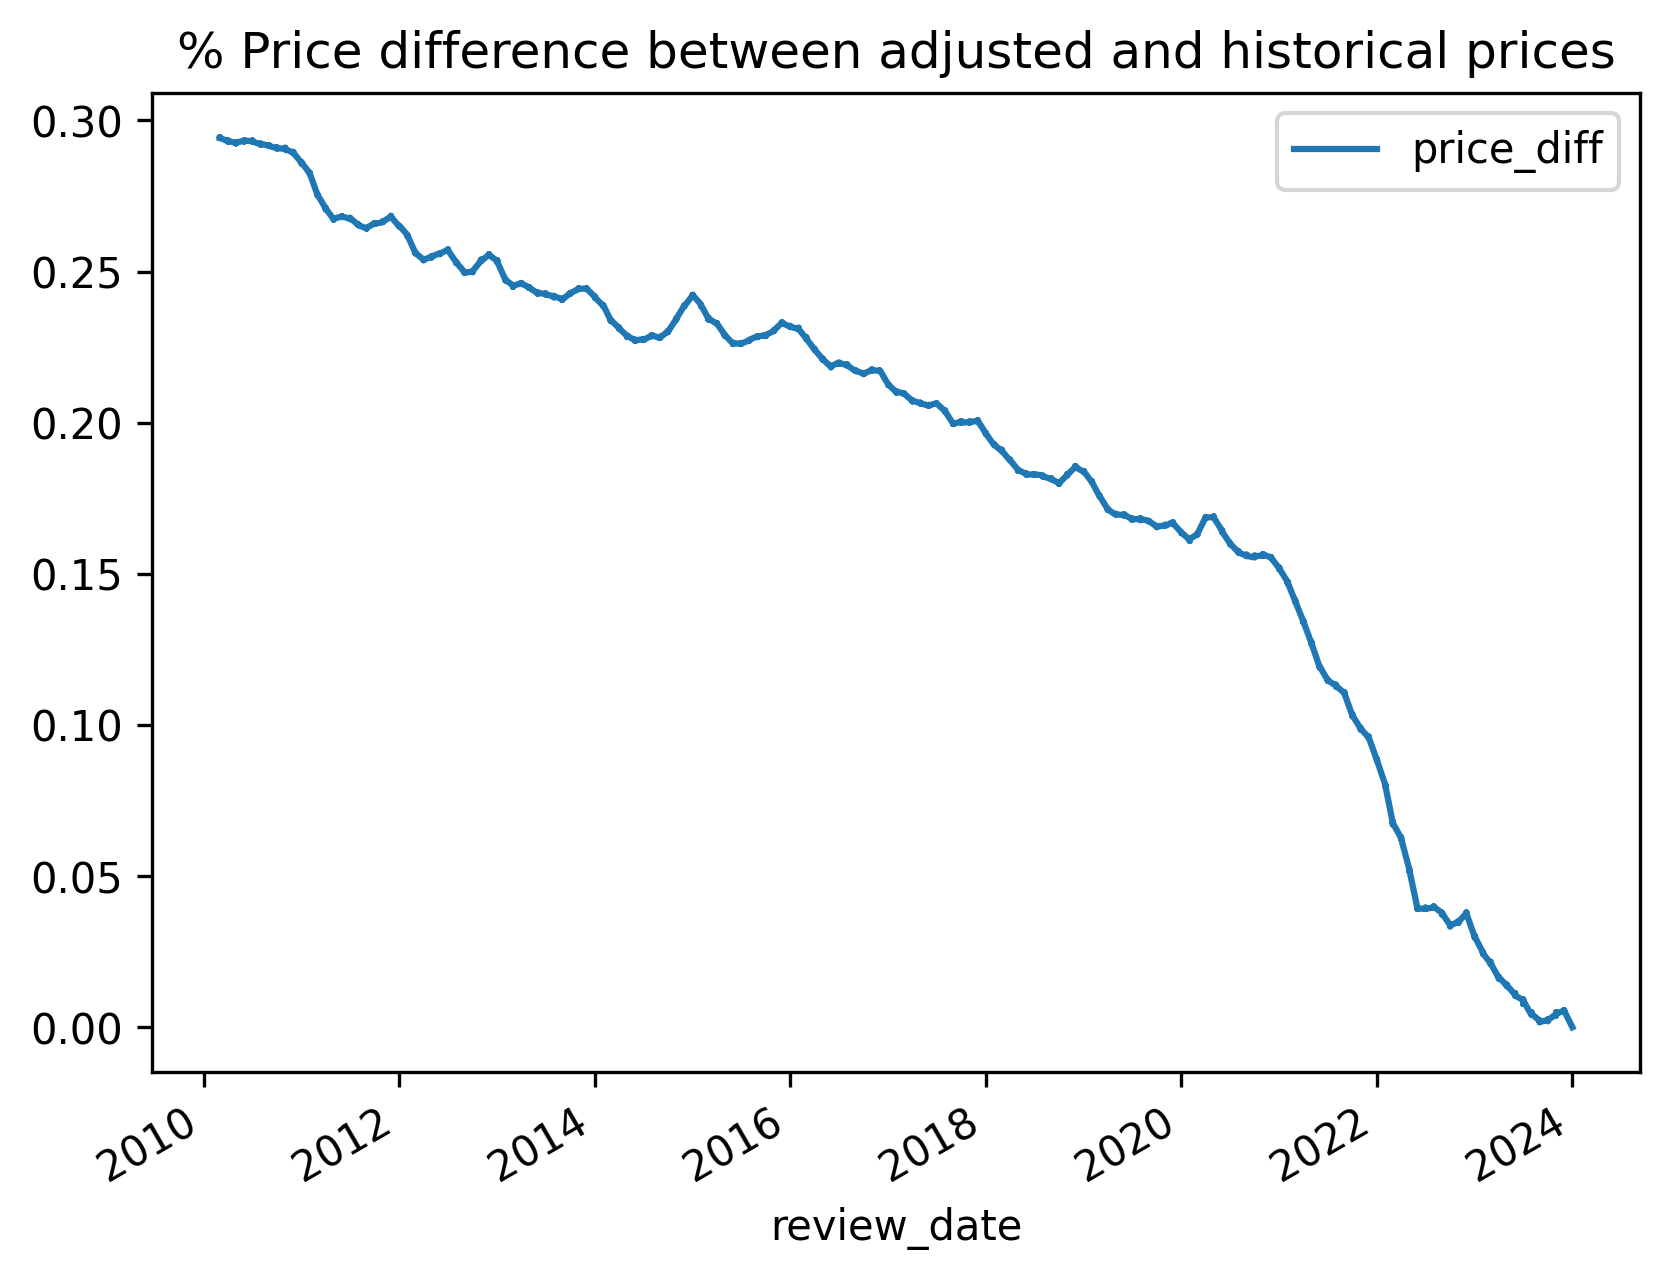

In [7]:

def load_transform_cpi(file_path: Path) -> pd.DataFrame:
    """Loads and transforms the CPI data."""
    MONTH_MAP = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    try:
        cpi = pd.read_csv(file_path, usecols=['Year',
                                              'Jan', 'Feb', 'Mar',
                                              'Apr', 'May', 'Jun',
                                              'Jul', 'Aug', 'Sep',
                                              'Oct', 'Nov', 'Dec'
                                              ]
                          )
    except FileNotFoundError:
        raise FileNotFoundError("CPI file is not found in the specified directory.")

    return (cpi
            .melt(id_vars='Year', var_name='Month', value_name='cpi')
            .assign(Month=lambda x: x['Month'].map(MONTH_MAP),
                    date=lambda x: pd.to_datetime(x[['Year', 'Month']].assign(day=1)))
            .dropna()
            .drop(columns=['Year', 'Month'])
            .rename(columns={'cpi': 'consumer_price_index'})
            .sort_values('date')
            .reset_index(drop=True)
           )
    
def create_cpi_adjusted_price(df: pd.DataFrame, file_path: Path, date: str='2024-01-01') -> pd.DataFrame:
    """
    Adjusts historical price data to 2024 prices using CPI data.
    """
    cpi = load_transform_cpi(file_path)
    cpi_baseline = cpi.loc[cpi['date'] == date, 'consumer_price_index'].values[0]
    
    return (df
            .merge(cpi, left_on="review_date", right_on="date")
            .drop(columns='date')
            .assign(price_usd_adj=lambda df_: np.round(
                df_['price_value_usd_hist'] * cpi_baseline / df_['consumer_price_index'], 2)
                    )
            )
    
data_dir = Path('../../data')
cpi_path = data_dir / 'external' / 'consumer_price_index.csv'

df = (df_raw
      .pipe(tweak_df)
      .pipe(price_quantity_split)
      .pipe(clean_currency)
      .pipe(convert_to_usd)
      .pipe(create_cpi_adjusted_price, file_path=cpi_path)
      )

df.sample(3)    

(
    df
    .assign(price_diff=lambda df_: (df_['price_usd_adj'] - df_['price_value_usd_hist'])/df_['price_usd_adj'])
).plot(x='review_date', y='price_diff', title='% Price difference between adjusted and historical prices')


### Converting quantities to lbs

In [47]:
def convert_to_lbs(df: pd.DataFrame) -> pd.DataFrame:
    to_lbs_conversion = {"ounces": 1/16, "pounds":1, "kilogram": 2.20462, "grams": 0.00220462}
    df['quantity_in_lbs'] = np.round(df['quantity_value'] * df['quantity_unit'].map(to_lbs_conversion), 2)
    return df

df =(df_raw
     .pipe(tweak_df)
     .pipe(price_quantity_split)
     .pipe(clean_currency)
     .pipe(convert_to_usd)
     .pipe(create_cpi_adjusted_price, file_path=cpi_path)
     .pipe(convert_to_lbs)
)

display(df.loc[:, ['quantity_value', 'quantity_unit', 'quantity_in_lbs']]
        .groupby("quantity_unit")
        .sample(3, replace=True)
)

,quantity_value,quantity_unit,quantity_in_lbs
1082,227.0,grams,0.50
650,200.0,grams,0.44
756,200.0,grams,0.44
3479,1.0,kilogram,2.20
3479,1.0,kilogram,2.20
3479,1.0,kilogram,2.20
503,10.0,ounces,0.62
2879,12.0,ounces,0.75
1123,12.0,ounces,0.75
3930,5.0,pounds,5.00


In [9]:
# Create a new column for price per pound
def price_per_lbs(df: pd.DataFrame) -> pd.DataFrame:
    df['price_per_lbs_adj'] = np.round(df['price_usd_adj'] / df['quantity_in_lbs'], 2)
    return df

df = (df_raw
      .pipe(tweak_df)
      .pipe(price_quantity_split)
      .pipe(clean_currency)
      .pipe(convert_to_usd)
      .pipe(create_cpi_adjusted_price, file_path=cpi_path)
      .pipe(convert_to_lbs)
      .pipe(price_per_lbs)
)

display(df.describe())

,rating,review_date,aroma,body,flavor,aftertaste,acidity,agtron_external,agtron_ground,quantity_value,price_value,price_value_usd_hist,consumer_price_index,price_usd_adj,quantity_in_lbs,price_per_lbs_adj
count,4274.000000,4274,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4232.000000,4232.000000
mean,92.675948,2018-01-30 07:07:53.373888768,8.751053,8.497426,8.912728,8.098971,8.408751,55.525737,74.073467,34.776556,313.115082,21.846341,257.277009,26.220620,0.673020,50.704308
min,75.000000,2010-03-01 00:00:00,5.000000,6.000000,3.000000,4.000000,5.000000,0.000000,29.000000,1.000000,3.300000,3.300000,217.631000,3.880000,0.040000,5.360000
25%,92.000000,2014-07-01 00:00:00,8.000000,8.000000,9.000000,8.000000,8.000000,53.000000,70.000000,12.000000,15.990000,14.950000,236.151000,18.410000,0.500000,25.600000
50%,93.000000,2018-10-01 00:00:00,9.000000,9.000000,9.000000,8.000000,8.000000,57.000000,76.000000,12.000000,19.450000,18.000000,252.038000,21.770000,0.750000,30.425000
75%,94.000000,2021-10-01 00:00:00,9.000000,9.000000,9.000000,8.000000,9.000000,60.000000,79.000000,12.000000,33.000000,22.942500,276.589000,26.270000,0.750000,41.345000
max,98.000000,2024-01-01 00:00:00,10.000000,10.000000,10.000000,10.000000,10.000000,86.000000,99.000000,554.000000,120000.000000,387.480000,308.417000,388.420000,6.000000,5180.000000
std,1.955998,NaN,0.523074,0.543556,0.473112,0.568939,0.607873,8.402629,8.839507,68.064454,3850.989265,16.673900,26.981851,19.456407,0.227317,123.361985


In [48]:
# list of US states
us_states_and_territories= [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
    'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
    'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
    'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
    'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
    'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming',
    'District of Columbia', 'Puerto Rico'
]

# Create a column for county. Set it eual to the value in territorial_entity_1 if it contains 'County'

def create_us_state(row):
    if row['territorial_entity_2'] in us_states_and_territories:
        return row['territorial_entity_2']
    elif row['territorial_entity_1'] in us_states_and_territories:
        return row['territorial_entity_1']
    elif row['og_roaster_location'].split(",")[-1].strip() in us_states_and_territories:
        return row['og_roaster_location'].split(",")[-1].strip()
    else:
        return np.nan


def create_county_and_state_columns(df: pd.DataFrame) -> pd.DataFrame:
    df['roaster_county'] = np.where(df['territorial_entity_1'].str.contains('County', na=False),
                                    df['territorial_entity_1'],
                                    np.nan)
    df['roaster_us_state'] = df.apply(create_us_state, axis=1)
    return df


df = (df_raw
      .pipe(tweak_df)
        .pipe(price_quantity_split)
        .pipe(clean_currency)
        .pipe(convert_to_usd)
        .pipe(create_cpi_adjusted_price, file_path=cpi_path)
        .pipe(convert_to_lbs)
        .pipe(price_per_lbs)
        .pipe(create_county_and_state_columns)
        
)


display(df.loc[df['roaster_country'] == 'USA', ['roaster_country', 'roaster_us_state', 'roaster_county']].info())

<class 'pandas.core.frame.DataFrame'>
Index: 3227 entries, 0 to 4231
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   roaster_country   3227 non-null   object
 1   roaster_us_state  3227 non-null   object
 2   roaster_county    2905 non-null   object
dtypes: object(3)
memory usage: 100.8+ KB


None

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4232 non-null   int64         
 1   roaster                           4232 non-null   object        
 2   title                             4232 non-null   object        
 3   blind_assessment                  4232 non-null   object        
 4   bottom_line                       2760 non-null   object        
 5   roaster_location                  4232 non-null   object        
 6   coordinate location               4232 non-null   object        
 7   og_roaster_location               4232 non-null   object        
 8   roaster_location_identifier       4232 non-null   object        
 9   territorial_entity_1              4231 non-null   object        
 10  territorial_entity_1_identifiers  4231 non-null 

In [50]:
# Checking origin country column
df.coffee_origin_country.unique()

array(['Colombia', 'Democratic Republic of the Congo', 'Honduras',
       'Ethiopia', 'Kenya', 'Guatemala', 'Costa Rica', 'Panama', 'Peru',
       'Mexico', 'Burundi', 'Papua New Guinea', 'El Salvador',
       'United States of America', 'Nicaragua', 'India', 'Taiwan',
       'Indonesia', 'Ecuador', 'Brazil', 'Uganda', 'Thailand', 'Rwanda',
       "People's Republic of China", 'Tanzania', 'Philippines', 'Yemen',
       'Bolivia', 'Vietnam', 'Haiti', 'Zambia', 'Malaysia',
       'Dominican Republic', 'Jamaica', 'South Africa', 'Nepal',
       'Madagascar', 'Saint Helena', 'Myanmar', 'Zimbabwe', 'Malawi'],
      dtype=object)

## Column Checks

In [51]:
df = (df_raw
        .pipe(tweak_df)
        .pipe(price_quantity_split)
        .pipe(clean_currency)
        .pipe(convert_to_usd)
        .pipe(create_cpi_adjusted_price, file_path=cpi_path)
        .pipe(convert_to_lbs)
        .pipe(price_per_lbs)
        .pipe(create_county_and_state_columns)
    )

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4232 non-null   int64         
 1   roaster                           4232 non-null   object        
 2   title                             4232 non-null   object        
 3   blind_assessment                  4232 non-null   object        
 4   bottom_line                       2760 non-null   object        
 5   roaster_location                  4232 non-null   object        
 6   coordinate location               4232 non-null   object        
 7   og_roaster_location               4232 non-null   object        
 8   roaster_location_identifier       4232 non-null   object        
 9   territorial_entity_1              4231 non-null   object        
 10  territorial_entity_1_identifiers  4231 non-null 

In [52]:
df_numeric = df.select_dtypes(include=['number']).drop(columns=['price_value'], axis=1)
len(df_numeric.columns)

14

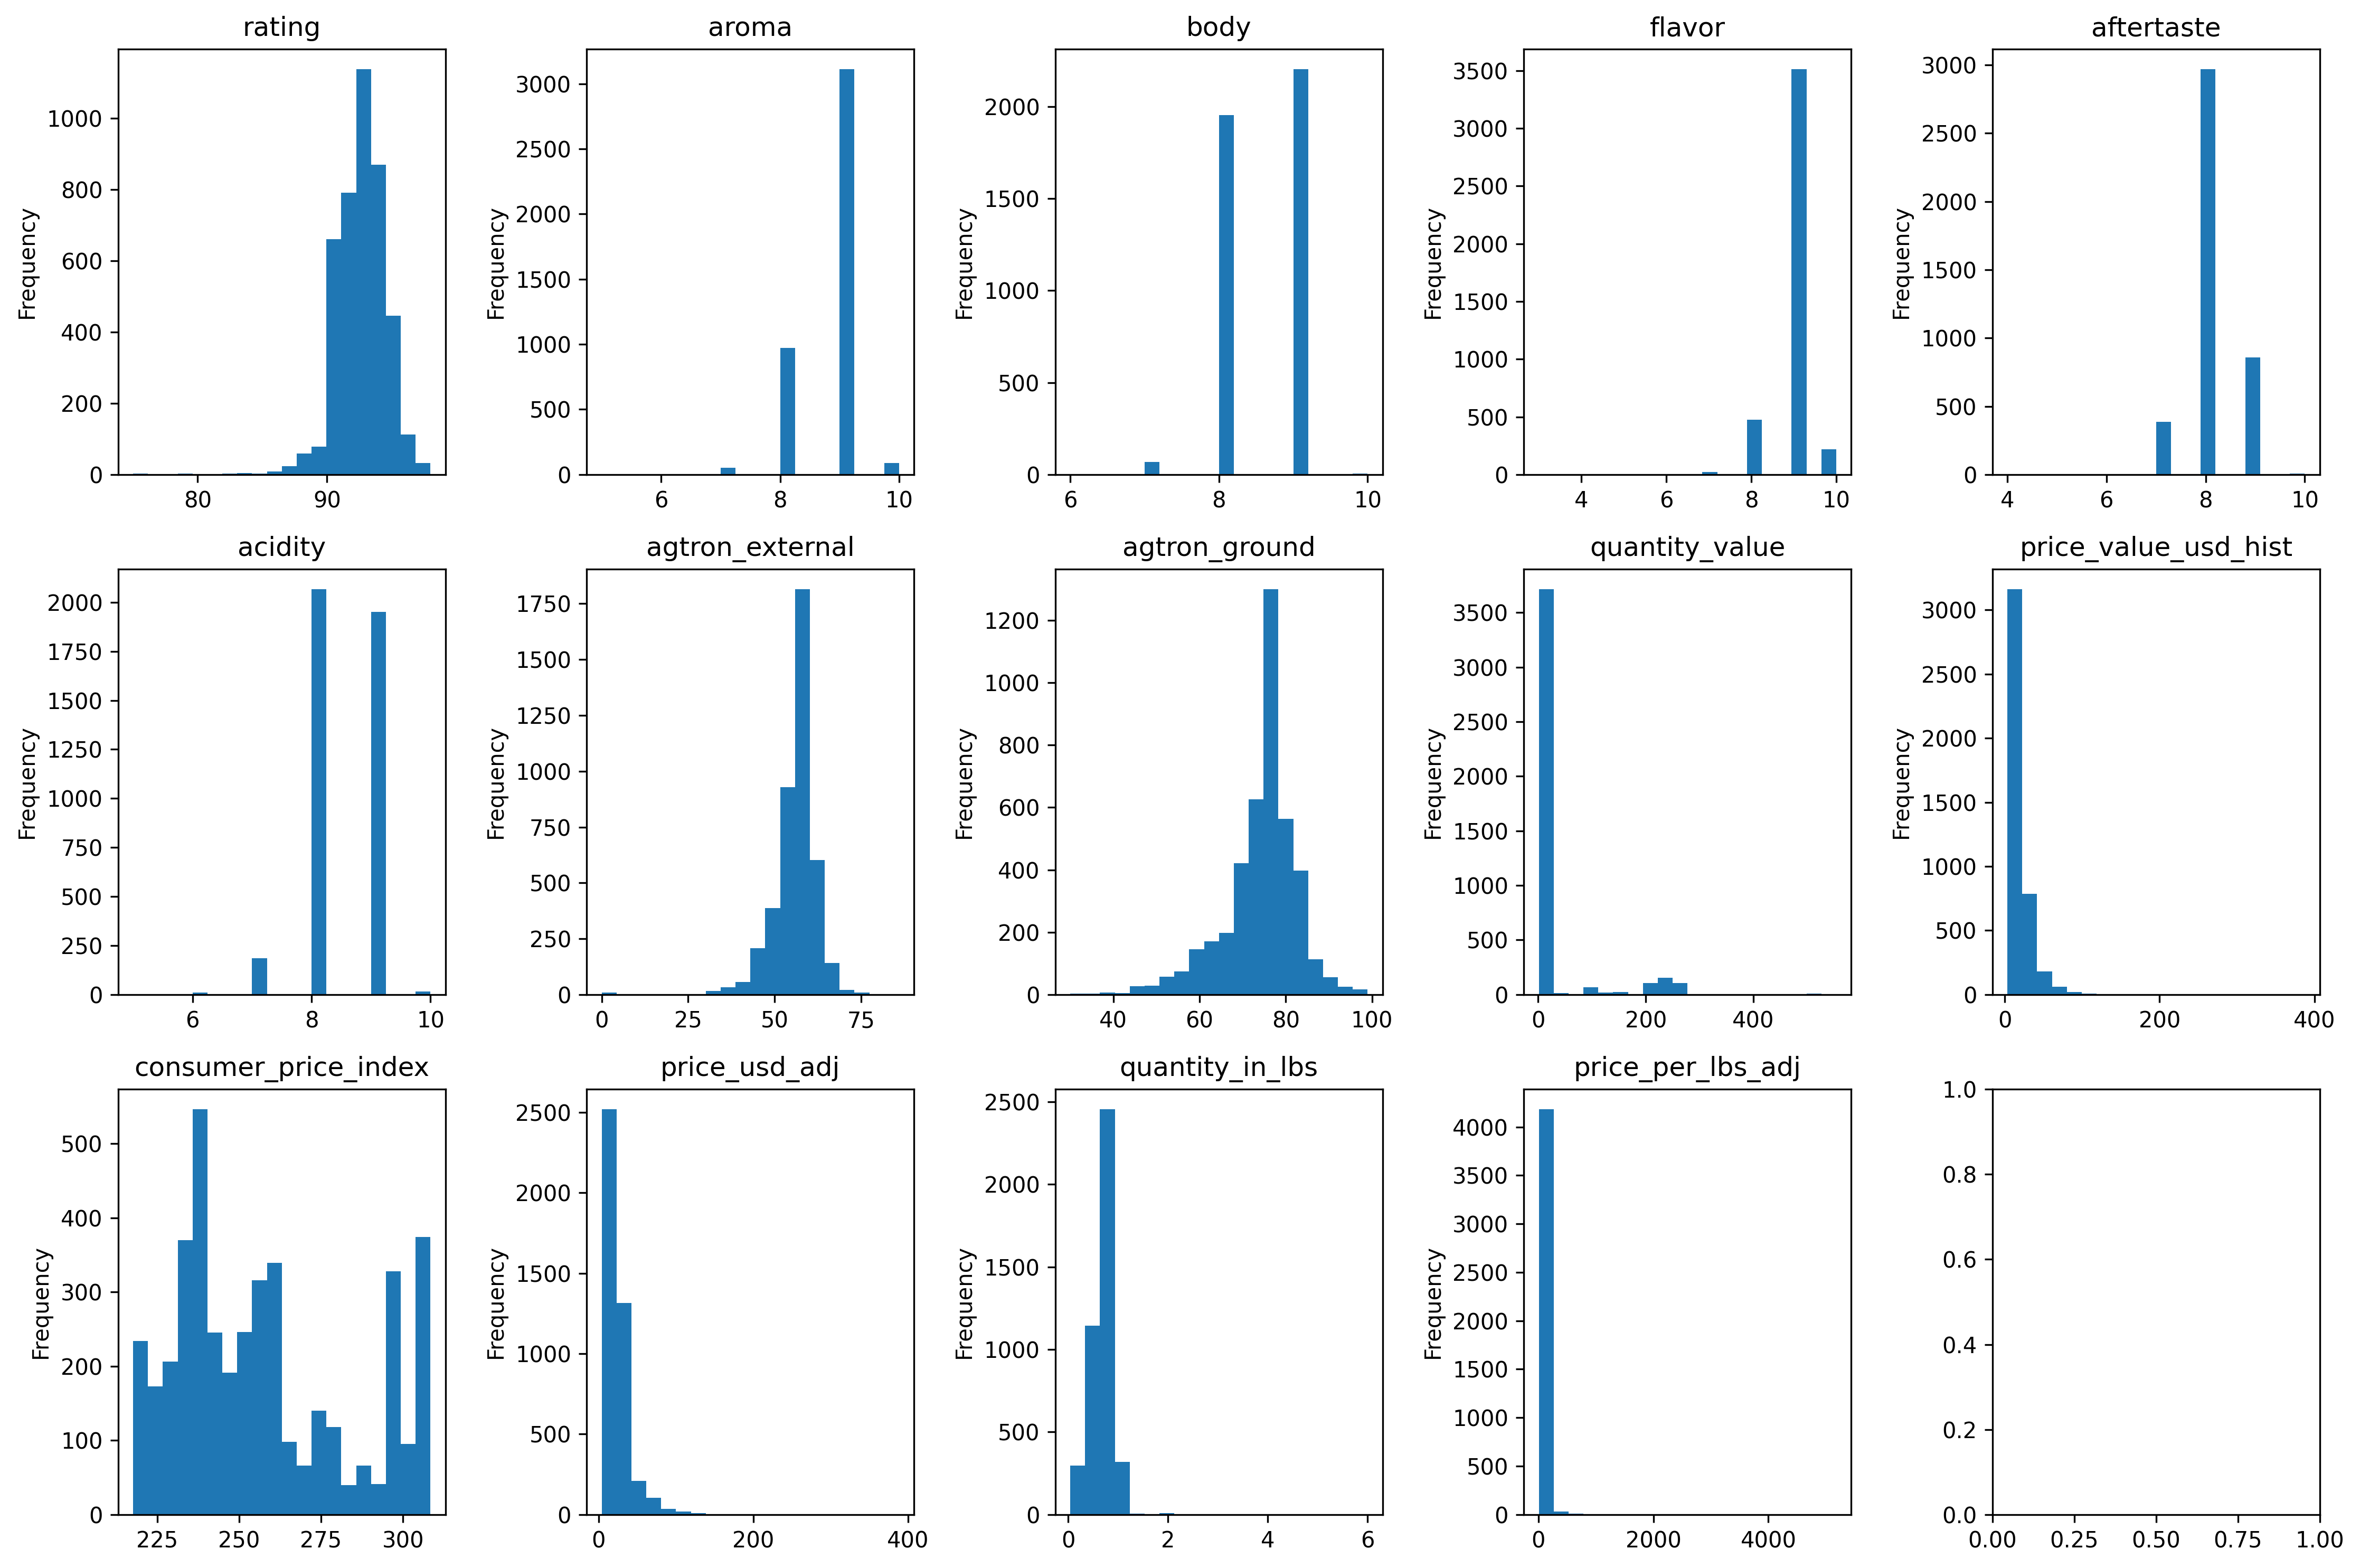

In [53]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10))

for i, col in enumerate(df_numeric.columns):
    df[col].plot(kind='hist', ax=ax[i//5, i%5], title=col, bins=20)
    
plt.tight_layout()
plt.show()